[View in Colaboratory](https://colab.research.google.com/github/Hyunjulie/Basic_ML/blob/master/GANbasics.ipynb)

GAN is a generative model that learns the probability distribution (or data distribution) of the training examples it is given



---

Generator: Tries to fool the discriminator (Create fake images)

Discrimator: Distinguish whether the image is real 




---

* Data: MNIST Training images 
* Generator network: takes in a random noise vector and produces a synthetic image 
* Discriminator network (CNN): learns to distinguish between real / synthetic image --> binary classifier (1 for real, 0 for fake image)
* Opimization Procedure: updates both networks through Stochastic Gradient Descent 
* Use Tensorflow 

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Loading MNIST Image 
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
# mnist variable contains both images and their labels -> extract only the images (size: 28 * 28)
x_train = mnist.train.images[:55000, :]
x_train.shape

(55000, 784)

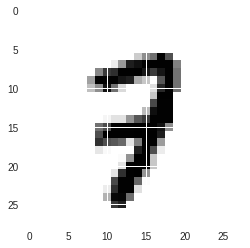

In [3]:
#Sample image 
randNum = random.randint(0,55000)
image = x_train[randNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

Discriminator Network 
--- 
CNN Classifier 
- input: 28 X 28  X 1 (black/white)
- output: (None, 2) - since it's a binary classifier 

In [0]:
def conv2d(x, W):
  return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
  return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [0]:
def discriminator(x_image, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
            
        #First Conv and Pool Layers
        W_conv1 = tf.get_variable('d_wconv1', [5, 5, 1, 8], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('d_bconv1', [8], initializer=tf.constant_initializer(0))
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = avg_pool_2x2(h_conv1)

        #Second Conv and Pool Layers
        W_conv2 = tf.get_variable('d_wconv2', [5, 5, 8, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = avg_pool_2x2(h_conv2)

        #First Fully Connected Layer
        W_fc1 = tf.get_variable('d_wfc1', [7 * 7 * 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*16])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        #Final Layer
        y_conv=(tf.matmul(h_fc1, W_fc2) + b_fc2)
    return y_conv

Generator Network
---
Based on the [DCGAN Paper](https://arxiv.org/pdf/1511.06434v2.pdf)

Similar with reverse ConvNet

Generator: seeks to take d-dimensional noise vector and upsample it to become 28 X 28 image 
- Done by convolutional transpose layer (deconvolutional)
- ReLUs and Batch Normalization is used to stabilize the outputs of each layer 

* [Conv Transpose --> ReLU --> Batch Norm] is repeated 4 times 
- Output volume grows larger and larger until 28 X 28 X 1 image is formed 
- z is a random noise

In [0]:
def generator(z, batch_size, z_dim, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        g_dim = 64 #Number of filters of first layer of generator 
        c_dim = 1 #Color dimension of output (MNIST is grayscale, so c_dim = 1 for us)
        s = 28 #Output size of the image
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16) #We want to slowly upscale the image, so these values will help
                                                                  #make that change gradual.

        h0 = tf.reshape(z, [batch_size, s16+1, s16+1, 25])
        h0 = tf.nn.relu(h0)
        #Dimensions of h0 = batch_size x 2 x 2 x 25

        #First DeConv Layer
        output1_shape = [batch_size, s8, s8, g_dim*4]
        W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv1
        H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        #Dimensions of H_conv1 = batch_size x 3 x 3 x 256

        #Second DeConv Layer
        output2_shape = [batch_size, s4 - 1, s4 - 1, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv2
        H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        #Dimensions of H_conv2 = batch_size x 6 x 6 x 128

        #Third DeConv Layer
        output3_shape = [batch_size, s2 - 2, s2 - 2, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv3
        H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        #Dimensions of H_conv3 = batch_size x 12 x 12 x 64

        #Fourth DeConv Layer
        output4_shape = [batch_size, s, s, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, 
                                         strides=[1, 2, 2, 1], padding='VALID') + b_conv4
        H_conv4 = tf.nn.tanh(H_conv4)
        #Dimensions of H_conv4 = batch_size x 28 x 28 x 1

    return H_conv4

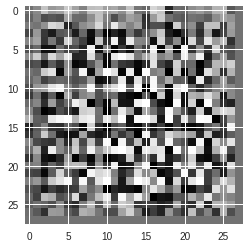

In [7]:
#Examine a untrained generator
sess = tf.Session()
z_dimensions = 100
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])
sample_image = generator(z_test_placeholder, 1, z_dimensions)
test_z = np.random.normal(-1, 1, [1,z_dimensions])

sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))

my_i = temp.squeeze() #.squeeze() removes dimensions of size 1 from the shape of a tensor 
plt.imshow(my_i, cmap='gray_r')
plt.show()

In [0]:
batch_size = 16
tf.reset_default_graph() 
#Changed batch size from 1 to 16 --> need to reset tensorflow graph

sess = tf.Session()
x_placeholder = tf.placeholder("float", shape = [None,28,28,1]) #input images to the discriminator 
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions]) #random noise

Loss Function
---

Generator wants the discriminator to output a 1 for its fake image 
- Compute the loss between Dg and label of 1 
- use tf.nn.sigmoid_cross_entropy_with_logits function 
* "with logits": function will operate on unscaled values (instead of using a softmax function to squish the output activations to probability values betwen 0 and 1, return the unscaled value of the matrix multiplication - Discriminator's last layer does not have softmax or sigmoid)


Discriminator
Goal: get the correct label (1 for MNIST real images, and 0 for generated images)
- Need to compute 2 losses: loss between Dx and the correct labels of 1 and loss between Dg and the correct label of 0 
- Simply add the two losses 

In [0]:
# Dx holds discriminator prediction probabilities for the real MNIST images
Dx = discriminator(x_placeholder)

# Gz holds generated images
Gz = generator(z_placeholder, batch_size, z_dimensions)

# Dg holds discriminator prediction probabilities for generated images 
Dg = discriminator(Gz, reuse=True)

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

Optimizers & Training
---

Generator: needs to only update the generator's weights, not those of the discriminator 
- Create 2 lists: one with discriminator's weights and one with generator's weights
* naming all variables come in handy 


In [10]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print(tf.get_variable_scope().reuse)
adam = tf.train.AdamOptimizer(learning_rate=0.0002)
trainerD = adam.minimize(d_loss, var_list=d_vars)
trainerG = adam.minimize(g_loss, var_list=g_vars)

False


**Training Loops**

For every iteration, there are two updates 
- Discriminator: Take a batch of images from MNIST variable (positive examples) & images made by the generator (negative examples)
- Generator: Feed in a random z vector to the generator and pass that output to the discriminator to obtain a probability score (Dg) --> Loss function updates only the generator's weights & biases


In [0]:
sess.run(tf.global_variables_initializer())
iterations = 300
for i in range(iterations):
  z_batch = np.random.normal(-1, 1, size=[batch_size, z_dimensions])
  real_image_batch = mnist.train.next_batch(batch_size)
  real_image_batch = np.reshape(real_image_batch[0], [batch_size, 28, 28, 1])

  #Update discriminator 
  _, dLoss = sess.run([trainerD, d_loss], feed_dict={z_placeholder:z_batch, x_placeholder:real_image_batch})
  #Update generator
  _, gLoss = sess.run([trainerG, g_loss], feed_dict={z_placeholder:z_batch})
  

In [0]:
sample_image = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(-1, 1, size=[1, z_dimensions])
temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')